# Data Challenge

## Summary

In this data challenge, we will explore the data, build predictive models, and use the models to predict duration of **test.csv** file. During exploring the data, roughly speaking, there exists linear relationship between Mahattan (Euclidean) distance and duration (see **Sec. 1**); thus **man_dist** is the most important feature in fitting model. From midnight to 2PM, a linear regression can provide good estimate on duration.

However, in other times, **after 3PM until midnight**, there exist one thousand anomaly events (**0.1% of the whole sample**), where the traveling duration time is much larger than usual expectation. The existence of these outliers is dependent on **times**, and **not likely to be relevnt to seasons and weekdays/weekend** (see analysis in **Sec. 2**). It is worth to note that about 17% of the anomaly points are relevant to the trips either heading to or coming from JFK airport (**Sec. 3**).  

**Many outliers happen in extremely short traveling distances and the trips are traveling in Mahattan only**. It is interesting to study why there are the anomaly duration trips. There are some potential reasons: road construction, car accidents and some unexpected traffic situations. But to further identify the origin of the outliers, we need more data to explore, e.g. traffic info and construction notification at the time. On the other hand, once we can rule out all possible reasons, and are sure the outliers are from (human) measurement errors, we can ignore the outliers to consider model to improve the accuracy.

I implement **ridge regression, i.e. linear regression model with L2 regularization** to train the model. The data amount is huge. If using 5/10-fold cross-validation to train model, it will cost a lot time, so I simply separate the dataset to training set and test set. In principle, **Random-forest regression** outperforms the linear regression model. For example, from midnight to 2PM (1AM, 2AM..10AM,..1PM, 2PM), the R squares could be 0.7, and in the worst case, 3PM, the R square is still 0.4 (see **Sec. 4**). Hence **in average random-forest is better than linear regression**. However, I did try building 24 RF models for 24 various times (hours) and make prediction on duration, the computation is extremely slow (**see pred_duration_rf.py**). Thus the durations in **duration.csv** are simply given by **ridge regression** on all data population.

I believe using the random-forest or decision-tree which can describe non-linear behavior can improve the results. If I have more time to finish the challenge, I should be able to improve it. For real-time, Naive Bayes regression is a good method to implement.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from time import time
import math
import time
import matplotlib.pyplot as plt
import pylab
from pylab import *
import matplotlib
import copy
matplotlib.style.use('ggplot')

%matplotlib inline

## 0. The Data

### 0-1: Training Dataset

In [2]:
data = pd.read_csv('train.csv')
data.shape

(12905715, 7)

In [3]:
data.head()

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration
0,0,-74.009087,40.713818,-74.004326,40.719986,1420950819,112
1,1,-73.971176,40.762428,-74.004181,40.742653,1420950819,1159
2,2,-73.994957,40.745079,-73.999939,40.734650,1421377541,281
3,3,-73.991127,40.750080,-73.988609,40.734890,1421377542,636
4,4,-73.945511,40.773724,-73.987434,40.755707,1422173586,705


### 0-2: Test Dataset

In [4]:
testData = pd.read_csv('test.csv')
testData.shape

(1434344, 6)

In [6]:
testData.head()

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp
0,0,-73.993111,40.724289,-74.000977,40.735222,1422173589
1,1,-73.971924,40.762749,-73.965698,40.771427,1420567340
2,2,-73.953247,40.765816,-73.952843,40.772453,1420567343
3,3,-73.986618,40.739353,-73.949158,40.805161,1420103336
4,4,-73.968864,40.757317,-73.982521,40.771305,1420690180


### 0-3: Data location - NYC

In [16]:
print (data['start_lng'].max(), data['start_lng'].min())
print (data['start_lat'].max(), data['start_lat'].min())

-73.414452 -74.514618
41.031418 40.368916


### 0-4: Data timestamp 2015-2016

In [25]:
print (datetime.datetime.fromtimestamp(data['start_timestamp'].max()).strftime('%Y-%m-%d %H:%M:%S'))
print (datetime.datetime.fromtimestamp(data['start_timestamp'].min()).strftime('%Y-%m-%d %H:%M:%S'))

2016-01-01 02:57:04
2015-01-01 03:00:03


On the other hand, we can convert local time to a timestamp:

In [27]:
time.mktime(time.strptime('2015-01-01 02:57:04', "%Y-%m-%d %H:%M:%S"))

1420099024.0

### 0-5: Functions 

In [48]:
def scatterplot(ax, title, x_label, y_label, x1, x2):
    s = ax.scatter(x1, x2, s=70, marker=(5, 0), cmap=plt.cm.jet, linewidths=0, alpha=0.7)
    #plt.colorbar(mappable=s, ax=ax)
    ax.set_xlabel(x_label, size=20)
    ax.set_ylabel(y_label, size=20)
    ax.set_title(title, size=20)
    plt.xlim(0,)
    plt.ylim(0,)
    
def scatterplot3D(ax, title, x_label, y_label, x1, x2, y):
    s = ax.scatter(x1, x2, s=70, c=y, marker=(5, 0), cmap=plt.cm.jet, linewidths=0, alpha=0.7)
    plt.colorbar(mappable=s, ax=ax)
    ax.set_xlabel(x_label, size=20)
    ax.set_ylabel(y_label, size=20)
    ax.set_title(title, size=20)
    xlim(0,)
    ylim(0,)
    
'''This function is used to compute RMSE and R square'''
def R_squared(predict, true):
    if len(predict) != len(true): return False
    meanTrue = np.mean(true)
    RSS =0
    TSS =0
    MAE =0
    for i in range(len(predict)):
        MAE += abs(predict[i]-true[i])
        RSS += (predict[i] - true[i])**2
        TSS += (true[i] - meanTrue)**2
    #return np.sqrt(RSS/len(predict)), 1.0-RSS/TSS
    return MAE/len(predict), 1.0-RSS/TSS

## 1. Preprocessing Training Dataset with traveling distance

### 1-1: Are there missing data?

In [7]:
data.isnull().sum()

row_id             0
start_lng          0
start_lat          0
end_lng            0
end_lat            0
start_timestamp    0
duration           0
dtype: int64

NO. There are no missing data. 

### 1-2:  Euclidean Distance

Note if directly performing `data['Euc_dist'] = data.apply(Euc_dist, axis = 1)`, where Euc_dist is the function to compute Euclidean distance, it is extremely slow. Thus I did the following:

In [36]:
dists = []
for x in data[['start_lng', 'start_lat','end_lng', 'end_lat']].values.tolist():
    x1 = x[0] ## start_lng
    y1 = x[1] ## start_lat
    x2 = x[2] ## end_lng
    y2 = x[3] ## end_lat
    dlon = x[2] - x[0]
    dlat = x[3] - x[1] 
    a = (math.sin(dlat/2))**2 + math.cos(y1) * math.cos(y2) * (math.sin(dlon/2))**2
    c = 2 * math.atan2( math.sqrt(a), math.sqrt(1-a) ) 
    dists.append(c)
    
data['euc_dist']=pd.Series(dists)

### 1-3: Mahattan Distance

In [5]:
data['man_dist'] = pd.Series(abs(data['start_lng']-data['end_lng'])+abs(data['start_lat']-data['end_lat']), index=data.index)

In [6]:
data.head()

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,man_dist
0,0,-74.009087,40.713818,-74.004326,40.719986,1420950819,112,0.010929
1,1,-73.971176,40.762428,-74.004181,40.742653,1420950819,1159,0.052780
2,2,-73.994957,40.745079,-73.999939,40.734650,1421377541,281,0.015411
3,3,-73.991127,40.750080,-73.988609,40.734890,1421377542,636,0.017708
4,4,-73.945511,40.773724,-73.987434,40.755707,1422173586,705,0.059940


### 1-4: Visualization of Distance Metrics vs Duration

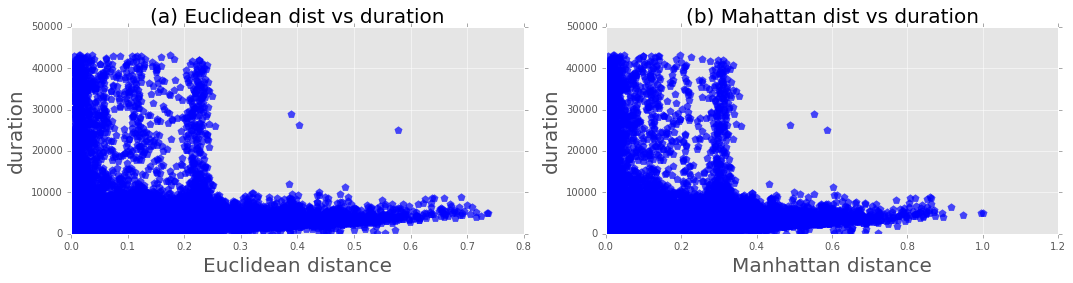

In [14]:
y = data.loc[:,'duration']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,4))
ax = plt.subplot(121)
scatterplot(ax, '(a) Euclidean dist vs duration', 'Euclidean distance', 'duration', data.loc[:,'euc_dist'], y);

ax = plt.subplot(122)
scatterplot(ax, '(b) Mahattan dist vs duration', 'Manhattan distance', 'duration', data.loc[:,'man_dist'], y);

fig.tight_layout()
plt.show()

**Note that here I skip to multiply $3651$ miles on both distances, so they are in terms of the unity.** Both distance metrics roughly shows **linear relation between distances and duration**, and have similar behavior. In this report, I **prefer  using the Mahattan distance** than Euclidean distance, since Euclidean distance is a straight distance between two points, but driving in a city needs to follow road structures.

In the followings, we will try to analyze the anomaly events which cause non-linearity, i.e. **the area as Mahattan distance <= 0.3 but duration > 10000 (arbitrary units)**. I used **duration > 10000** since even longest distances, the approximate duration is still below 10000. The rough estimate on the number of anomaly events is

In [33]:
data[data['duration']>10000].shape[0]

1608

Considered that the total number of events is **12,905,715**, the ratio of the anomaly events (meaning that the duration is much longer than its expectation) over all events is only $r =1608/12905715=0.000125 = 0.125\%$. In this case, we can regard the anomaly events as **outliers**. The existence of the outliers however will influence the model fitting. Thus we will spend time to find out whether or not there exist hidden features relevant to the data.

## 2. Preprocessing Training Dataset with Timestamp

In the data, we need to convert the timestamp to more straightforward information.

In [8]:
months = []
hours = []
wdays = []
weekend = []
dates = []
for i in data['start_timestamp']:
    localTime = time.localtime(i)
    month = localTime.tm_mon
    hour = localTime.tm_hour
    wday = localTime.tm_wday+1
    date = localTime.tm_mday
    months.append(month)
    hours.append(hour)
    wdays.append(wday)
    dates.append(date)
    if wday == 6 or wday ==7: 
        weekend.append(1)
    else:
        weekend.append(0)

In [9]:
data['month']=pd.Series(months)
data['day']=pd.Series(dates)
data['wday']=pd.Series(wdays)
data['weekend']=pd.Series(weekend)
data['hour']=pd.Series(hours)
del data['row_id']

In [10]:
data.head()

,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,man_dist,month,day,wday,weekend,hour
0,-74.009087,40.713818,-74.004326,40.719986,1420950819,112,0.010929,1,10,6,1,23
1,-73.971176,40.762428,-74.004181,40.742653,1420950819,1159,0.052780,1,10,6,1,23
2,-73.994957,40.745079,-73.999939,40.734650,1421377541,281,0.015411,1,15,4,0,22
3,-73.991127,40.750080,-73.988609,40.734890,1421377542,636,0.017708,1,15,4,0,22
4,-73.945511,40.773724,-73.987434,40.755707,1422173586,705,0.059940,1,25,7,1,3


In this subsection, we will attempt to explore what potential features are relvant to the anomaly events, i.e. the events where the traveling distances are short but the durations are unusual. We visualize the data using Mahattan distance vs duration **(a) 2-1: seasonly (b) 2-2: weekly (c) 2-3: hourly**.

### 2-1: Are the anomaly large durations relevant to seasons?

First we may wonder if the existence of the anomaly large duration events depends on **seasons**? Maybe it is because of holiday season? To answer this, we indictae 7 **Manhattan distance (X) vs duration (Y) plots** from different months: Jan., March, May, July, Sept. Nov. and Dec. (I actually checked every month):

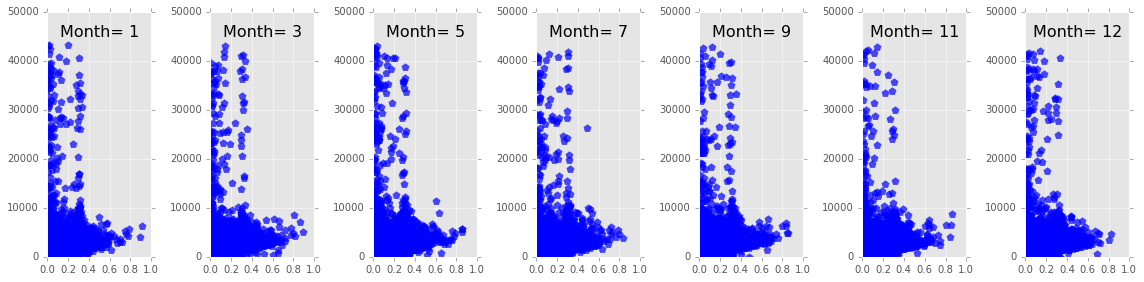

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=7, figsize = (16,4))
index = 1
for months in [1,3,5,7,9,11,12]:
    filterData = data[data['month']==months]
    x1 = filterData.loc[:,'man_dist']
    x2 = filterData.loc[:,'duration']
    ax = plt.subplot(int(str(17)+str(index)))
    s = ax.scatter(x1, x2, s=70, marker=(5, 0), cmap=plt.cm.jet, linewidths=0, alpha=0.7)
    ax.text(.5, 0.9, 'Month= '+str(months), horizontalalignment='center', transform=ax.transAxes, size =16)
    plt.xlim(0,)
    plt.ylim(0,50000)
    index += 1
    
fig.tight_layout()
plt.show()

We can see during the whole year, the anomaly events all exist. Thus it is not likely mainly becuase of seasons. It is more intutitive to check the ratio of anomaly events over all events on each month:

In [40]:
for month in range(1,13):
    filterData = data[data['month']==month]
    print (month, round(filterData[filterData['duration'] > 10000].shape[0]/filterData.shape[0],7))

1 0.000134
2 0.0001205
3 0.0001096
4 0.0001144
5 0.0001552
6 0.0001212
7 0.0001339
8 0.0001396
9 0.0001301
10 0.0001001
11 0.0001039
12 0.0001335


### 2-2: Are the anomaly large durations relevant to weekday or weekend?

Are the anomaly duration events becuase of traffic from **rush hours**? We can examine **Manhattan distance (X) vs duration (Y) plots** on every weekday. If it is true, we should observe the anomaly duration events be less frequent during weekends (Saturday and Sunday: 6,7) than weekdays (Monday-Friday: 1-5).

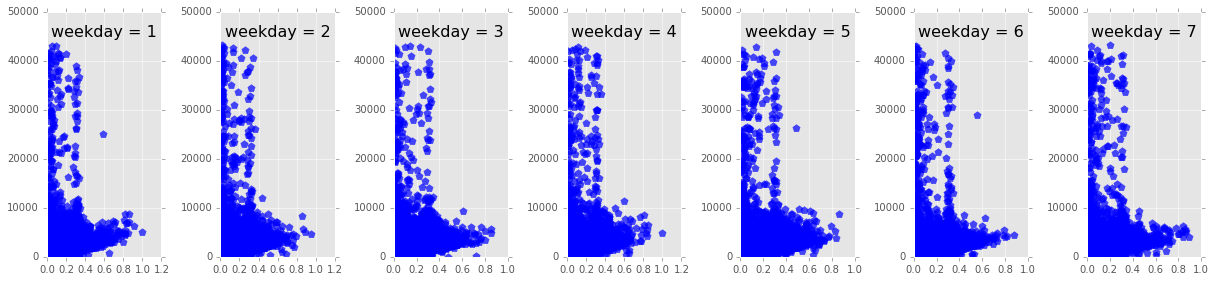

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=7, figsize = (17,4))
index = 1
for weekdays in range(1,8):
    filterData = data[data['wday']== weekdays]
    x1 = filterData.loc[:,'man_dist']
    x2 = filterData.loc[:,'duration']
    ax = plt.subplot(int(str(17)+str(index)))
    s = ax.scatter(x1, x2, s=70, marker=(5, 0), cmap=plt.cm.jet, linewidths=0, alpha=0.7)
    ax.text(.5, 0.9, 'weekday = '+str(weekdays), horizontalalignment='center', transform=ax.transAxes, size =16)
    plt.xlim(0,)
    plt.ylim(0,50000)
    index += 1
    
fig.tight_layout()
plt.show()

We can see during the whole week, the anomaly events all exist every day. Thus it is not likely mainly becuase of rush hour traffic. (Of course, NYC always has traffic.) To further confirm our observations, we can also check the ratios:

In [41]:
for weekday in range(1,8):
    filterData = data[data['wday']==weekday]
    print (weekday, round(filterData[filterData['duration'] > 10000].shape[0]/filterData.shape[0],7))

1 0.000134
2 0.0001389
3 0.0001107
4 0.0001167
5 0.000119
6 0.0001305
7 0.0001244


### 2-3: Are the anomaly large durations relevant to time during a day?

Finally, we discovered the anomaly durations are relevant to the **times** during a day. First, the anomaly events do not exist (or rarely happen) in the early morning and after midnight:

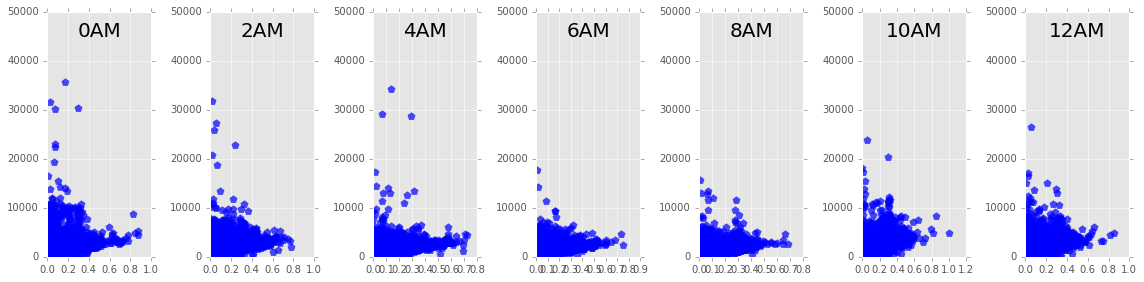

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=7, figsize = (16,4))
index = 1
for hours in range(0,13,2):
    filterData = data[data['hour']==hours]
    x1 = filterData.loc[:,'man_dist']
    x2 = filterData.loc[:,'duration']
    ax = plt.subplot(int(str(17)+str(index)))
    s = ax.scatter(x1, x2, s=70, marker=(5, 0), cmap=plt.cm.jet, linewidths=0, alpha=0.7)
    ax.text(.5, 0.9, str(hours)+'AM', horizontalalignment='center', transform=ax.transAxes, size =20)
    plt.xlim(0,)
    plt.ylim(0,50000)
    index += 1 
    
fig.tight_layout()
plt.show()

However, once **after 3PM afternoon**, the anomaly large duration events launch!

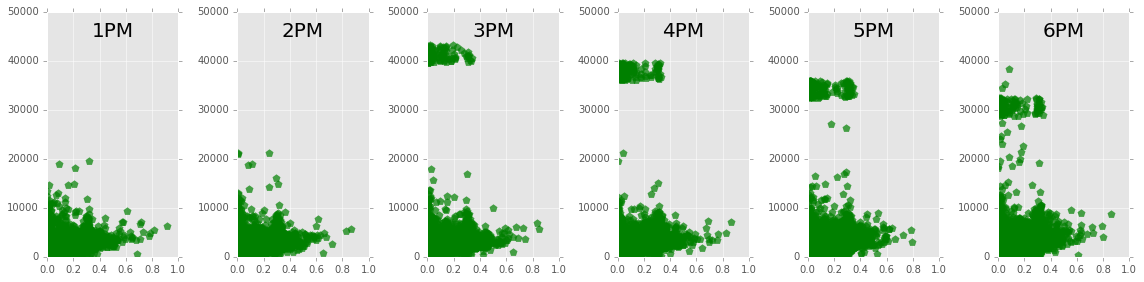

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize = (16,4))
index =1
for hours in range(13,19):
    filterData = data[data['hour']==hours]
    x1 = filterData.loc[:,'man_dist']
    x2 = filterData.loc[:,'duration']
    ax = plt.subplot(int(str(16)+str(index)))
    s = ax.scatter(x1, x2, s=70, marker=(5, 0), cmap=plt.cm.jet, linewidths=0, alpha=0.7, color='g')
    ax.text(.5, 0.9, str(hours-12)+'PM', horizontalalignment='center', transform=ax.transAxes, size =20)
    plt.xlim(0,)
    plt.ylim(0,50000)
    index += 1
    
fig.tight_layout()
plt.show()

We can see the presence of the anomaly duration events are last until midnight 11PM:

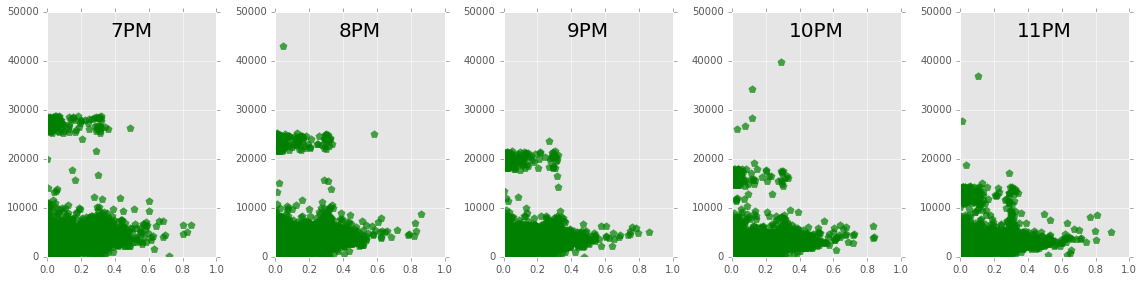

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize = (16,4))
index=1
for hours in range(19,24):
    filterData = data[data['hour']==hours]
    x1 = filterData.loc[:,'man_dist']
    x2 = filterData.loc[:,'duration']
    ax = plt.subplot(int(str(15)+str(index)))
    s = ax.scatter(x1, x2, s=70, marker=(5, 0), cmap=plt.cm.jet, linewidths=0, alpha=0.7, color='g')
    ax.text(.5, 0.9, str(hours-12)+'PM', horizontalalignment='center', transform=ax.transAxes, size =20)
    plt.xlim(0,)
    plt.ylim(0,50000)
    index += 1
    
fig.tight_layout()
plt.show()

From separating the events in each different time, we can see how the anomaly events evolve. The duration develops at 3PM, and the duration attitude descreases upon time, and eventually merge to the lower normal portion. 
**It is weak to claim the existence of the outliers is due to rush hour traffic, since the outliers exist both in weekday and weekend. Meanwhile, in the early morning, 7-9AM, there are no much anomaly events too.**

We can combine the plots in a colored scatter chart:

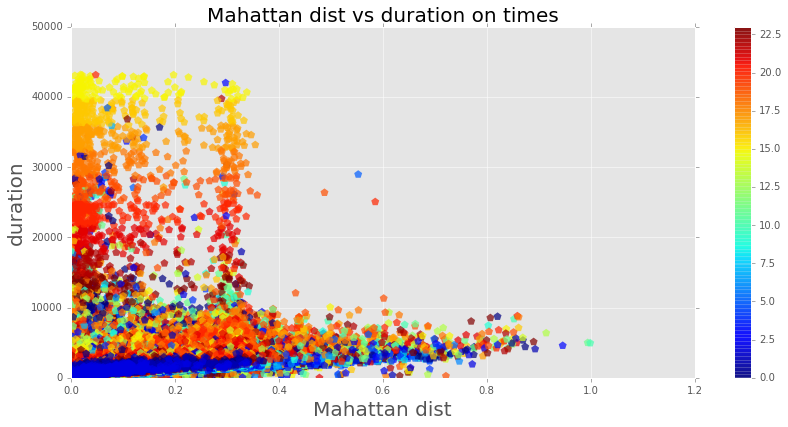

In [53]:
x1 = data.loc[:,'man_dist']
x2 = data.loc[:,'duration']
y = data.loc[:,'hour']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12,6))
ax = plt.subplot(111)
scatterplot3D(ax, 'Mahattan dist vs duration on times', 'Mahattan dist', 'duration', x1, x2, y);

fig.tight_layout()
plt.show()

## 3. Locations of the Anomaly Duration Events 

Next we can ask whether the **anomaly duration events occur on some certain locations**? Can we further find other relevant features which trigger such anomaly large durations? I found some of the events are relevant to trips from Mahattan to JFK airports or from JFK to Mahattan. For example, 

In [19]:
anomaly = data[data['duration'] > 10000]

In [21]:
anomaly[anomaly['hour']==17].head()

,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,man_dist,month,day,wday,weekend,hour
115933,-73.990150,40.735279,-73.991539,40.727211,1420408838,35962,0.009457,1,4,7,1,17
124110,-73.790436,40.646408,-73.972809,40.756027,1420844364,26244,0.291992,1,9,5,0,17
156466,-73.783653,40.648769,-73.992805,40.713112,1422224158,35042,0.273495,1,25,7,1,17
157244,-73.788216,40.641460,-74.004265,40.721863,1420843977,32823,0.296452,1,9,5,0,17
178615,-74.002373,40.739689,-74.001678,40.735516,1421100800,35200,0.004868,1,12,1,0,17


We can see starting places of the events **156466**, **157244** and **157244** with man_dist ~ 0.3 actually have destination as JFK airport.

### 3-1: Location visualization on anomaly duration events

Using **Basemap** package to visualize the anomaly events in NYC.

In [2]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [11]:
anomaly = data[data['duration'] > 10000]

In [23]:
anomaly.to_csv('outliers.csv')
starts = np.genfromtxt("outliers.csv", delimiter=',', dtype=[('lat', np.float32), ('lon', np.float32)], usecols=(2, 1))
ends = np.genfromtxt("outliers.csv", delimiter=',', dtype=[('lat', np.float32), ('lon', np.float32)], usecols=(4, 3))

In [13]:
themap = Basemap(projection='gall', 
            llcrnrlon = -74.17756700000001,  llcrnrlat = 40.636581, urcrnrlon = -73.751274, urcrnrlat = 40.824982,
            resolution = 'h', area_thresh = 0.01)

### 3-2: Anomaly events' starting locations

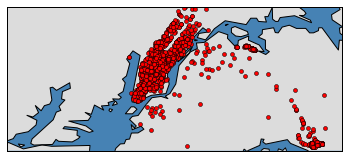

In [24]:
themap.drawcoastlines()
themap.drawcountries()
themap.fillcontinents(color = 'gainsboro')
themap.drawmapboundary(fill_color='steelblue')
x, y = themap(starts['lon'], starts['lat'])
themap.plot(x, y, 'o', color='red', markersize=4)
plt.show()

### 3-3: Anomaly events' ending locations

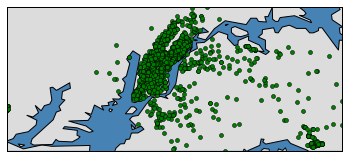

In [26]:
themap.drawcoastlines()
themap.drawcountries()
themap.fillcontinents(color = 'gainsboro')
themap.drawmapboundary(fill_color='steelblue')
x, y = themap(ends['lon'], ends['lat'])
themap.plot(x, y, 'o', color='green', markersize=4)
plt.show()

We can see some of the anomaly events are the trips to JFK or from JFK, and others involve Mahattan. The Manhattan distance between Mahattan and JFK is roughly 0.25~0.3. Thus the ratio can be roughly estimated as

In [33]:
print (anomaly[anomaly['man_dist'] >= 0.25].shape[0]/anomaly.shape[0])

0.17599502487562188


Therefore, **once the trips occur in the afternoon and heading to JFK or from JFK, there is some probability (17%) to happen anomaly duration. However, there is no obvious evidence and specific preference on the locations of the outlier events.**

**Personal conjecture: many of outliers happen in extremely short traveling distances. This could be many reasons: road construction, car accidents and some unexpected situations. But we need more data to identfity the origin of the outliers.**

## 4. Regression Models

To build predictive models, I chosen to separate data to different times. First reason is that different times have different traffic, as well as the mean driving speed. The second reason is that before 3PM, the anomaly duration events rarely exist; thus linear regression should be a good model. After the time, models are needed to consider the existence of outliers. I will use Rigde regression for 10-fold cross validation, and decision-tree and random forest for 5-fold crossvalidation. Here I will also try **Robust Regression** model to compare naive linear regression and others.

**Note during training models, I still prefer to keep 'lng' and 'lats' as numeric numbers, rather than turning them to zipcodes. In this case, regression can possibly select locations as features to interpret the outliers. For each model, we use the metric (MAE, R squares) to measure the performace (MAE = mean absolute error) .**

In [13]:
data.head()

,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,man_dist,month,day,wday,weekend,hour
0,-74.009087,40.713818,-74.004326,40.719986,1420950819,112,0.010929,1,10,6,1,23
1,-73.971176,40.762428,-74.004181,40.742653,1420950819,1159,0.052780,1,10,6,1,23
2,-73.994957,40.745079,-73.999939,40.734650,1421377541,281,0.015411,1,15,4,0,22
3,-73.991127,40.750080,-73.988609,40.734890,1421377542,636,0.017708,1,15,4,0,22
4,-73.945511,40.773724,-73.987434,40.755707,1422173586,705,0.059940,1,25,7,1,3


In [14]:
from sklearn import linear_model
from sklearn import grid_search
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [15]:
trainData = data[['start_lng','start_lat','end_lng','end_lat','duration','man_dist','month','wday','hour']]

In [16]:
trainData.head()

,start_lng,start_lat,end_lng,end_lat,duration,man_dist,month,wday,hour
0,-74.009087,40.713818,-74.004326,40.719986,112,0.010929,1,6,23
1,-73.971176,40.762428,-74.004181,40.742653,1159,0.052780,1,6,23
2,-73.994957,40.745079,-73.999939,40.734650,281,0.015411,1,4,22
3,-73.991127,40.750080,-73.988609,40.734890,636,0.017708,1,4,22
4,-73.945511,40.773724,-73.987434,40.755707,705,0.059940,1,7,3


### 4-1: Converting categorical variables to OEH

**month**, **wday** and **hour** are categorical variables. Later we will build models on different times, but **month**  **wday** are needed to convert to OEH representation. To do it, we need to assign the variables as categorical variables:

In [17]:
trainData['month'] = trainData['month'].astype('category');
trainData['wday']  = trainData['wday'].astype('category');

/Users/hhhung/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/hhhung/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [18]:
trainData = pd.get_dummies(trainData)

In [19]:
trainData.head()

,start_lng,start_lat,end_lng,end_lat,duration,man_dist,hour,month_1,month_2,month_3,...,month_10,month_11,month_12,wday_1,wday_2,wday_3,wday_4,wday_5,wday_6,wday_7
0,-74.009087,40.713818,-74.004326,40.719986,112,0.010929,23,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-73.971176,40.762428,-74.004181,40.742653,1159,0.052780,23,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-73.994957,40.745079,-73.999939,40.734650,281,0.015411,22,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,-73.991127,40.750080,-73.988609,40.734890,636,0.017708,22,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,-73.945511,40.773724,-73.987434,40.755707,705,0.059940,3,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
trainData.shape

(12905715, 26)

In [52]:
best_lasso_model = None
max_rscore = -1
best_lambda = -1
for lambda_i in [1e-2, 0.05, 0.1, 1.0, 2.0, 5.0]:
    lasso = linear_model.Lasso(alpha=lambda_i)
    cv_score = cross_val_score(lasso, X_train, y_train, cv=10)
    print (lambda_i, np.mean(cv_score))
    if np.mean(cv_score) > max_rscore:
        max_rscore = np.mean(cv_score)
        best_lasso_model = lasso
        best_lambda = lambda_i
        
best_lasso_model.fit(X_train, y_train)
predictedY = best_lasso_model.predict(X_test)
print (best_lambda, R_squared(predictedY, y_test))

/Users/hhhung/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not co

0.01 0.613352535838
0.05 0.613352676932
0.1 0.613352590704
1.0 0.613304189376
2.0 0.613156223941
5.0 0.612200627673
0.05 (276.56247483768487, 0.63019983829454784)


In [55]:
best_lasso_model.coef_

array([  6.27628764e+01,   6.70979089e+00,  -8.47568967e+01,
         2.19046240e+01,   5.16730751e+02,  -9.48130138e+00,
        -5.30785667e-02,   0.00000000e+00,  -3.50611807e+00,
         3.65765291e+00,   1.84597717e+00,  -8.06403851e+00,
        -1.06673412e+01,   3.70310282e+00,   5.32503289e+00,
         7.15586333e+00,  -7.90808255e+00,  -6.36575145e+00,
         1.37581728e+01,   9.62896365e+00,   1.17380414e+01,
        -0.00000000e+00,  -8.18907317e+01,  -9.40766561e+01])

### 4-1: Case I: Models with (rare) outliers

Here the example model is shown using 11AM. In this case, there are no many outliers, and we can see linear regression gives good prediction.

In [56]:
X = trainData[trainData['hour'] == 11]
y = trainData[trainData['hour'] == 11]['duration']
del X['duration']
del X['hour']

In [57]:
X.head()

,start_lng,start_lat,end_lng,end_lat,man_dist,month_1,month_2,month_3,month_4,month_5,...,month_10,month_11,month_12,wday_1,wday_2,wday_3,wday_4,wday_5,wday_6,wday_7
68,-73.982414,40.735325,-73.992615,40.730412,0.015114,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
69,-73.972191,40.748806,-73.983490,40.762192,0.024685,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
165,-73.990578,40.746185,-73.870766,40.773975,0.147602,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
256,-74.008034,40.731812,-74.009499,40.726044,0.007233,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
257,-74.007751,40.732082,-73.973557,40.762886,0.064998,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [58]:
from sklearn.cross_validation import cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2);
X_train.shape, y_train.shape;
y_test = y_test.tolist();

### 4-1(a): Ridge linear regression

#### -- Without standardization 

In [60]:
best_ridge_model = None
max_rscore = -1
best_lambda = -1
for lambda_i in [1e-2, 0.05, 0.1, 0.2, 1.0, 2.0, 3.0, 5.0]:
    ridge = linear_model.Ridge(alpha=lambda_i)
    cv_score = cross_val_score(ridge, X_train, y_train, cv=10)
    print (lambda_i, np.mean(cv_score))
    if np.mean(cv_score) > max_rscore:
        max_rscore = np.mean(cv_score)
        best_ridge_model = ridge
        best_lambda = lambda_i
        
best_ridge_model.fit(X_train, y_train)
ridge_pred = best_ridge_model.predict(X_test)
print (best_lambda, R_squared(ridge_pred, y_test))

0.01 0.61867475993
0.05 0.618674773155
0.1 0.618674784589
0.2 0.618674790484
1.0 0.618674027586
2.0 0.61867107179
3.0 0.618665928343
5.0 0.618649232731
0.2 (278.54439835887274, 0.6091097170471792)


The MAE is 278.544 and the R square is 0.609.

In [61]:
best_ridge_model.coef_

array([  1.81673896e+03,   2.77393751e+02,  -2.50657779e+03,
         7.95115713e+02,   1.04075707e+04,  -2.58701920e+01,
         4.53129515e+00,   5.35303223e+00,  -6.10593407e+00,
         1.71640110e+01,   1.17916237e+01,  -2.26155011e+01,
        -3.64336652e+01,   2.09228276e+01,   2.39000789e+01,
         3.28103275e+01,  -2.54479037e+01,   6.65448126e+01,
         1.21416326e+02,   1.08936381e+02,   1.16206554e+02,
         8.58392432e+01,  -2.07016309e+02,  -2.91927008e+02])

From the coefficients, we can see the fifth one, **man_dist** has largest weights, hinting that it is the most important feature. Interestingly, the **start_lng** and **end_lng** are also relatively more relevant than others.

#### -- With standardization

In [62]:
from sklearn import preprocessing

In [72]:
X_train_scaled = preprocessing.scale(X_train)
X_train_scaled[:2]

array([[ 0.04313585, -0.1329262 , -0.14660636, -0.53261209, -0.40027469,
        -0.30532926, -0.30743817, -0.32152024, -0.32178492,  3.20021629,
        -0.30899484, -0.29526043, -0.28332988, -0.28677552, -0.30475206,
        -0.28325012, -0.28473195, -0.42787055, -0.45635846, -0.4668487 ,
        -0.46350592,  2.24823289, -0.30711531, -0.26527368],
       [ 0.16076492,  0.4347627 ,  0.4115514 ,  0.75303204, -0.56731606,
        -0.30532926, -0.30743817, -0.32152024,  3.10766585, -0.31247888,
        -0.30899484, -0.29526043, -0.28332988, -0.28677552, -0.30475206,
        -0.28325012, -0.28473195, -0.42787055, -0.45635846, -0.4668487 ,
        -0.46350592,  2.24823289, -0.30711531, -0.26527368]])

In [65]:
X_train_scaled.mean(axis=0)

array([  1.34074318e-14,   1.71523216e-13,   2.31241625e-13,
         2.11876317e-14,   2.24190434e-16,   1.92608719e-18,
         6.27315897e-17,  -4.76018691e-17,   4.20376172e-18,
        -3.48530063e-18,   6.41723335e-17,   4.02643941e-17,
        -6.37748869e-17,  -3.12301280e-17,  -4.35815442e-17,
        -1.54698431e-17,   2.97779194e-17,  -3.67332342e-17,
        -5.22795094e-18,   3.41192588e-17,  -8.71325157e-18,
        -5.72380374e-17,   5.76603244e-17,   5.40527325e-17])

In [67]:
X_train_scaled.std(axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [68]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [79]:
scaler.transform(X_train)[:2]

array([[ 0.04313585, -0.1329262 , -0.14660636, -0.53261209, -0.40027469,
        -0.30532926, -0.30743817, -0.32152024, -0.32178492,  3.20021629,
        -0.30899484, -0.29526043, -0.28332988, -0.28677552, -0.30475206,
        -0.28325012, -0.28473195, -0.42787055, -0.45635846, -0.4668487 ,
        -0.46350592,  2.24823289, -0.30711531, -0.26527368],
       [ 0.16076492,  0.4347627 ,  0.4115514 ,  0.75303204, -0.56731606,
        -0.30532926, -0.30743817, -0.32152024,  3.10766585, -0.31247888,
        -0.30899484, -0.29526043, -0.28332988, -0.28677552, -0.30475206,
        -0.28325012, -0.28473195, -0.42787055, -0.45635846, -0.4668487 ,
        -0.46350592,  2.24823289, -0.30711531, -0.26527368]])

In [75]:
## a new sample:
new_sample = np.array([[-73.98, 40.74, -74.0, 40.73, 0.015, 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])
scaler.transform(new_sample)

array([[-0.19949588, -0.51930421, -0.70785609, -0.82394229, -0.53362231,
         3.27515282, -0.30743817, -0.32152024, -0.32178492, -0.31247888,
        -0.30899484, -0.29526043, -0.28332988, -0.28677552, -0.30475206,
        -0.28325012, -0.28473195, -0.42787055, -0.45635846, -0.4668487 ,
        -0.46350592, -0.44479378, -0.30711531,  3.7696918 ]])

In [77]:
X_test_scaled = scaler.transform(X_test)

In [81]:
best_ridge_model = None
max_rscore = -1
best_lambda = -1
for lambda_i in [1e-2, 0.05, 0.1, 0.2, 1.0, 2.0, 3.0, 5.0]:
    ridge = linear_model.Ridge(alpha=lambda_i)
    cv_score = cross_val_score(ridge, X_train_scaled, y_train, cv=10)
    print (lambda_i, np.mean(cv_score))
    if np.mean(cv_score) > max_rscore:
        max_rscore = np.mean(cv_score)
        best_ridge_model = ridge
        best_lambda = lambda_i
        
best_ridge_model.fit(X_train_scaled, y_train)
ridge_pred = best_ridge_model.predict(X_test_scaled)
print (best_lambda, R_squared(ridge_pred, y_test))

0.01 0.618674756065
0.05 0.618674756097
0.1 0.618674756138
0.2 0.618674756218
1.0 0.61867475686
2.0 0.61867475765
3.0 0.618674758429
5.0 0.618674759948
5.0 (278.53456202379562, 0.60910689156308928)


In [83]:
best_ridge_model.coef_

array([  62.55540462,    7.57604324,  -86.01202624,   21.90557313,
        517.83759617,   -7.29935988,    1.19821871,    1.48155957,
         -1.85941538,    4.80831665,    3.24928719,   -6.21622887,
         -9.6277242 ,    5.47159822,    6.58927177,    8.53238922,
         -6.7737803 ,    8.40584332,   29.50522783,   25.1594858 ,
         27.81732546,   15.79647133,  -70.25203798,  -83.08442017])

### 4-1(b): Lasso

#### -- Without standardizarion

In [84]:
best_lasso_model = None
max_rscore = -1
best_lambda = -1
for lambda_i in [1e-2, 0.05, 0.1, 1.0, 2.0, 5.0]:
    lasso = linear_model.Lasso(alpha=lambda_i)
    cv_score = cross_val_score(lasso, X_train, y_train, cv=10)
    print (lambda_i, np.mean(cv_score))
    if np.mean(cv_score) > max_rscore:
        max_rscore = np.mean(cv_score)
        best_lasso_model = lasso
        best_lambda = lambda_i
        
best_lasso_model.fit(X_train, y_train)
predictedY = best_lasso_model.predict(X_test)
print (best_lambda, R_squared(predictedY, y_test))

/Users/hhhung/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not co

0.01 0.618673642215
0.05 0.618640669489
0.1 0.618535233283
1.0 0.611059008632
2.0 0.595892133329
5.0 0.573462743289
0.01 (278.54604140215537, 0.60911797177505611)


/Users/hhhung/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [85]:
best_lasso_model.coef_

array([  1.80980558e+03,   2.65160941e+02,  -2.49111936e+03,
         7.82298911e+02,   1.04006966e+04,  -3.03855235e+01,
        -0.00000000e+00,   6.08240592e-01,  -1.06189493e+01,
         1.24333852e+01,   7.04956324e+00,  -2.71229807e+01,
        -4.09307696e+01,   1.61622394e+01,   1.91556046e+01,
         2.80422821e+01,  -2.99394444e+01,   3.42236375e+00,
         5.82799665e+01,   4.57749385e+01,   5.30226383e+01,
         2.26504403e+01,  -2.70008439e+02,  -3.54885081e+02])

#### -- With standardizaiton

In [86]:
best_lasso_model = None
max_rscore = -1
best_lambda = -1
for lambda_i in [1e-2, 0.05, 0.1, 1.0, 2.0, 5.0]:
    lasso = linear_model.Lasso(alpha=lambda_i)
    cv_score = cross_val_score(lasso, X_train_scaled, y_train, cv=10)
    print (lambda_i, np.mean(cv_score))
    if np.mean(cv_score) > max_rscore:
        max_rscore = np.mean(cv_score)
        best_lasso_model = lasso
        best_lambda = lambda_i
        
best_lasso_model.fit(X_train_scaled, y_train)
predictedY = best_lasso_model.predict(X_test_scaled)
print (best_lambda, R_squared(predictedY, y_test))

/Users/hhhung/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/hhhung/anaconda/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not co

0.01 0.618674790693
0.05 0.618674884168
0.1 0.618674727613
1.0 0.618626334396
2.0 0.618476596936
5.0 0.617519656293
0.05 (278.5316422860152, 0.60910729752203396)


In [87]:
best_lasso_model.coef_

array([  6.25231000e+01,   7.52364804e+00,  -8.59111113e+01,
         2.18414059e+01,   5.17740222e+02,  -8.63169696e+00,
        -1.41878493e-01,   0.00000000e+00,  -3.24847813e+00,
         3.35854967e+00,   1.81341226e+00,  -7.50588116e+00,
        -1.08758658e+01,   4.12144367e+00,   5.16749547e+00,
         7.19053569e+00,  -8.02303883e+00,  -6.96073025e+00,
         1.33720658e+01,   8.78068155e+00,   1.15122555e+01,
        -0.00000000e+00,  -8.21623521e+01,  -9.35945269e+01])

### 4-1(c): Decision Tree

In [88]:
decTreeReg = DecisionTreeRegressor(random_state=10)
parameters = {'max_depth':[5,15,20,25,30],'min_samples_leaf':[5,10,20,30]}
model_cv_grid = grid_search.GridSearchCV(decTreeReg,parameters,cv=5, verbose=2,n_jobs=-1);
model_cv_grid.fit(X_train,y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] ........................ max_depth=5, min_samples_leaf=5 -   5.3s[CV] ........................ max_depth=5, min_samples_leaf=5 -   5.3s[CV] ........................ max_depth=5, min_samples_leaf=5 -   4.6s[CV] ........................ max_depth=5, min_samples_leaf=5 -   4.7s



[CV] max_depth=5, min_samples_leaf=10 ................................
[CV] max_depth=5, min_samples_leaf=10 ................................[CV] max_depth=5, min_samples_leaf=5 .................................[CV] max_depth=5, min_samples_leaf=10 ................................[CV] ....................... max_depth=5, min_samples_leaf=10 -   4.7s



[CV] ....................... max_depth=5, min_samples_leaf=10 -   4.6s[CV] ..

In [89]:
best_tree_model = model_cv_grid.best_estimator_
best_tree_model

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=30, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=10,
           splitter='best')

In [90]:
best_tree_model.fit(X_train, y_train)
tree_pred = best_tree_model.predict(X_test)
print (R_squared(tree_pred, y_test))

(206.4276605352926, 0.74488979715321357)


### 4-1(d): Random forest

Due to the tendious time on training random forest models, here I use singlet shoot, not grid search. However, the regression outcome also shows the most important feature is **man_dist**. Random forest model outperforms the decision tree and ridge regression.

In [91]:
rfReg = RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=100, verbose=0, warm_start=False)
rfReg.fit(X_train, y_train)
rf_pred = rfReg.predict(X_test)
print (R_squared(rf_pred, y_test))

(193.35076621832673, 0.76342489800053071)


In [92]:
importance = rfReg.feature_importances_
attribute = X.columns
v = sorted(range(len(importance)), key=lambda k: importance[k], reverse=True)
sorted_importance = [importance[i] for i in v]
sorted_attribute = [attribute[i] for i in v]
df_importance = pd.DataFrame({'variable': sorted_attribute, 'importance' : sorted_importance})
df_importance.sort_index().head(7)

,importance,variable
0,0.581544,man_dist
1,0.137429,start_lng
2,0.067212,end_lng
3,0.061826,end_lat
4,0.053250,start_lat
5,0.027007,wday_7
6,0.024545,wday_6


### 4-1(e): Model comparison

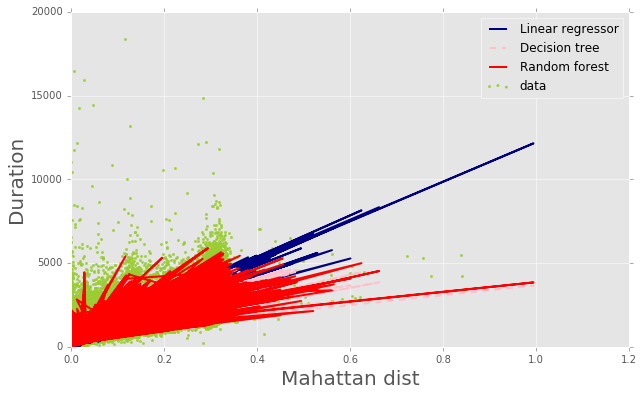

In [93]:
plt.figure(figsize=(10,6))
plt.scatter(np.array(X_train['man_dist']), np.array(y_train), color='yellowgreen', marker='.', label='data')
plt.plot(np.array(X_test['man_dist']), ridge_pred, color='navy', linestyle='-', linewidth=2, label='Linear regressor')
plt.plot(np.array(X_test['man_dist']), tree_pred, color='pink', linestyle='--', linewidth=2, label='Decision tree')
plt.plot(np.array(X_test['man_dist']), rf_pred, color='red', linestyle='-', linewidth=2, label='Random forest')
plt.xlabel('Mahattan dist', size=20)
plt.ylabel('Duration', size=20)
plt.legend(loc='upper right')
xlim(0,)
ylim(0,20000)
plt.show()

### 4-2: Case II: Models with outliers

Here the example model is shown using 3PM, where there are outliers. We will see the linear regression gives poor prediction.

In [94]:
X2 = trainData[trainData['hour'] == 15]
y2 = trainData[trainData['hour'] == 15]['duration']
del X2['duration']
del X2['hour']

In [95]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2);
X2_train.shape, y2_train.shape;
y2_test = y2_test.tolist();

In [96]:
scaler2 = preprocessing.StandardScaler().fit(X2_train)

In [97]:
X2_train_scaled = scaler2.transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)

### 4-2(a): Ridge Regression without Standardization

In [98]:
best_ridge_model = None
max_rscore = -1
best_lambda = -1
for lambda_i in [1e-2, 0.05, 0.1, 0.2, 1.0, 2.0, 3.0, 5.0]:
    ridge = linear_model.Ridge(alpha=lambda_i)
    cv_score = cross_val_score(ridge, X2_train, y2_train, cv=10)
    print (lambda_i, np.mean(cv_score))
    if np.mean(cv_score) > max_rscore:
        max_rscore = np.mean(cv_score)
        best_ridge_model = ridge
        best_lambda = lambda_i
        
best_ridge_model.fit(X2_train, y2_train)
ridge_pred = best_ridge_model.predict(X2_test)
print (best_lambda, R_squared(ridge_pred, y2_test))

0.01 0.371267488544
0.05 0.371267507908
0.1 0.371267529457
0.2 0.371267563714
1.0 0.371267415744
2.0 0.371266187692
3.0 0.371263819935
5.0 0.371255745836
0.2 (314.47140972109747, 0.35578126504384111)


### 4-2(a): Ridge Regression with Standardization

In [99]:
best_ridge_model = None
max_rscore = -1
best_lambda = -1
for lambda_i in [1e-2, 0.05, 0.1, 0.2, 1.0, 2.0, 3.0, 5.0]:
    ridge = linear_model.Ridge(alpha=lambda_i)
    cv_score = cross_val_score(ridge, X2_train_scaled, y2_train, cv=10)
    print (lambda_i, np.mean(cv_score))
    if np.mean(cv_score) > max_rscore:
        max_rscore = np.mean(cv_score)
        best_ridge_model = ridge
        best_lambda = lambda_i
        
best_ridge_model.fit(X2_train_scaled, y2_train)
ridge_pred = best_ridge_model.predict(X2_test_scaled)
print (best_lambda, R_squared(ridge_pred, y2_test))

0.01 0.371267483417
0.05 0.371267483454
0.1 0.3712674835
0.2 0.371267483593
1.0 0.371267484331
2.0 0.371267485248
3.0 0.371267486156
5.0 0.371267487951
5.0 (314.46198990967548, 0.35578002889732763)


### 4-2(b): Robust Regression

In [115]:
best_ransac_model = None
max_rscore = -1
best_lambda = -1
for lambda_i in [1e-2, 0.05, 0.1, 0.2, 1.0, 2.0, 3.0, 5.0]:
    model_ransac = linear_model.RANSACRegressor(linear_model.Ridge(alpha=lambda_i))
    cv_score = cross_val_score(model_ransac, X2_train, y2_train, cv=10)
    print (lambda_i, np.mean(cv_score))
    if np.mean(cv_score) > max_rscore:
        max_rscore = np.mean(cv_score)
        best_ransac_model = model_ransac
        best_lambda = lambda_i
        
best_ransac_model.fit(X2_train, y2_train)
ransac_pred = best_ransac_model.predict(X2_test)
print (best_lambda, R_squared(ransac_pred, y2_test))

0.01 0.263995147217
0.05 0.20877060147
0.1 0.206979035433
0.2 0.189313409655
1.0 0.215417372329
2.0 0.218962407062
3.0 0.224148604686
5.0 0.222654489963
0.01 (721.0539284506209, 0.28236169224927576)


### 4-3(c): Decision tree

In [100]:
decTreeReg = DecisionTreeRegressor(random_state=10)
parameters = {'max_depth':[5,15,20,25,30],'min_samples_leaf':[5,10,20,30]}
model_cv_grid = grid_search.GridSearchCV(decTreeReg,parameters,cv=5, verbose=2,n_jobs=-1)
model_cv_grid.fit(X2_train,y2_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] max_depth=5, min_samples_leaf=5 .................................
[CV] ........................ max_depth=5, min_samples_leaf=5 -   5.4s[CV] ........................ max_depth=5, min_samples_leaf=5 -   5.7s[CV] ........................ max_depth=5, min_samples_leaf=5 -   5.6s[CV] ........................ max_depth=5, min_samples_leaf=5 -   5.5s



[CV] max_depth=5, min_samples_leaf=5 .................................[CV] max_depth=5, min_samples_leaf=10 ................................[CV] max_depth=5, min_samples_leaf=10 ................................[CV] max_depth=5, min_samples_leaf=10 ................................



[CV] ........................ max_depth=5, min_samples_leaf=5 -   4.8s[CV] ....................... max_depth=5, min_samples_leaf=10 -   4.8s[CV] ...

In [102]:
best_tree_model = model_cv_grid.best_estimator_
best_tree_model.fit(X2_train, y2_train)
tree_pred = best_tree_model.predict(X2_test)
print (R_squared(tree_pred, y2_test))

(245.17890761250553, 0.42942687204610086)


### 4-3(d): Random forest

In [103]:
rfReg = RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=100, verbose=0, warm_start=False)
rfReg.fit(X2_train, y2_train)
rf_pred = rfReg.predict(X2_test)
print (R_squared(rf_pred, y2_test))

(230.96171102975381, 0.39193140632399015)


In [104]:
importance = rfReg.feature_importances_
attribute = X.columns
v = sorted(range(len(importance)), key=lambda k: importance[k], reverse=True)
sorted_importance = [importance[i] for i in v]
sorted_attribute = [attribute[i] for i in v]
df_importance = pd.DataFrame({'variable': sorted_attribute, 'importance' : sorted_importance})
df_importance.sort_index().head(7)

,importance,variable
0,0.482415,man_dist
1,0.108031,end_lng
2,0.105083,end_lat
3,0.102847,start_lng
4,0.088940,start_lat
5,0.012767,wday_7
6,0.010501,wday_6


### 4-3(e): Linear regression and robust regression models

In the followings, we just visualize the comparison between the linear regression model and the robust regression model. We can see that due to the outliers, the linear regression line is pushed upward. However, the robust regression still performs as the case without outliers. The regression process considers a certain probability to balance outliers and inliers. Here I used [RANSAC](http://scikit-learn.org/stable/modules/linear_model.html#ransac-random-sample-consensus) algorithm for the robust regression.

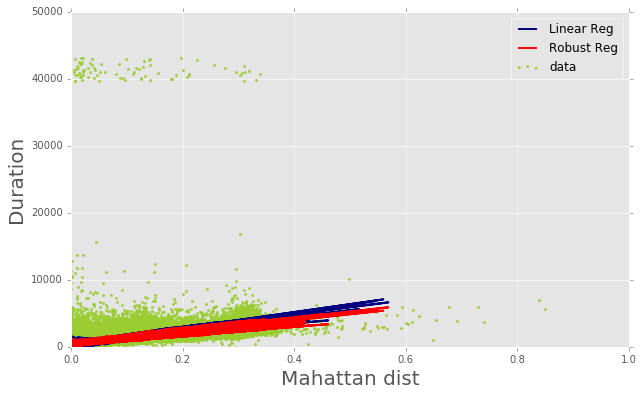

In [117]:
plt.figure(figsize=(10,6))
plt.scatter(np.array(X2_train['man_dist']), np.array(y2_train), color='yellowgreen', marker='.', label='data')
plt.plot(np.array(X2_test['man_dist']), ridge_pred, color='navy', linestyle='-', linewidth=2, label='Linear Reg')
#plt.plot(np.array(X2_test['man_dist']), tree_pred, color='pink', linestyle='--', linewidth=2, label='Decision tree')
plt.plot(np.array(X2_test['man_dist']), ransac_pred, color='red', linestyle='-', linewidth=2, label='Robust Reg')
plt.xlabel('Mahattan dist', size=20)
plt.ylabel('Duration', size=20)
plt.legend(loc='upper right')
xlim(0,)
ylim(0,50000)
plt.show()

## 5. Generate output file

run **pred_duration2.py** to generate **duration.csv**.